## Import and preprocess datasets

In [3]:
import numpy as np
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.ensemble.forest import RandomForestRegressor, RandomForestClassifier
import os
from sklearn import preprocessing, metrics
from importlib import reload
import sknn.mlp
from sklearn import tree  #for graphing random forest tree
import pickle
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
inline_rc = dict(mpl.rcParams)
import src.nnload as nnload
import src.nntrain as nntrain
import src.nnnetcdf as nnnetcdf
import src.nnplot as nnplot

# Set script parameters
minlev = 0.0
rainonly = False
write_nn_to_netcdf = False
fig_dir = './figs/'
data_dir = './data/'

# Load data
x, y, Pout, lat, lev, dlev, timestep = nnload.loaddata(data_dir + 'nntest.nc', minlev)

# Ensure that input and outputs are lined up in time!
x=x[1:,:]
y=y[0:-1,:]

# Print some statistics about rain and limit to when it's raining if True
x, y, Pout = nnload.limitrain(x, y, Pout, rainonly)
    
# Store when convection occurs
cv = nnload.whenconvection(y)
        
# Normalize input using the scikit-learn preprocessing tools
# Constrain inputs and outputs between 0 and 1
# Since outputs are sparse, don't shift the mean
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1.0,1.0))
scaler_y = preprocessing.MaxAbsScaler()

# Randomly choose samples
samples = np.random.choice(x.shape[0], x.shape[0], replace=False)
x1,x2,x3    = nnload.pp(x,  samples, scaler_x)
y1,y2,y3    = nnload.pp(y,  samples, scaler_y)
cv1,cv2,cv3 = nnload.pp(cv, samples, None, scale_data=False)

There is some amount of rain 61.0% of the time
There is a rate of >3 mm/day 20.2% of the time
There is convection 65.5% of the time


## Create, train, evaluate, and store regressors NN's

In [ ]:
# Build, train, and save model
from importlib import reload
reload(nntrain)
batch_size = 100
r_mlp, r_str                  = nntrain.build_nn('regress',['Rectifier'],[600],'momentum',batch_size,
                                                 n_stable=25)#, regularize = 'L2', weight_decay = 0.0001)
print(r_str)
r_mlp, r_errors = nntrain.train_nn(r_mlp,r_str,x1,y1,x2,y2)
pickle.dump([r_mlp, r_str, r_errors],  open(data_dir + 'regressors/' + r_str + '.pkl', 'wb'))

# Save model in netcdf format if requested
if write_nn_to_netcdf:
    nnnetcdf.write_netcdf_twolayer(r_mlp, 'regress', datadir + 'netcdf_models/' + r_str + '_neural_weights_regressor.nc')

r_600R_mom0.9


## Compare all NNs to each other

/Users/jgdwyer/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/jgdwyer/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


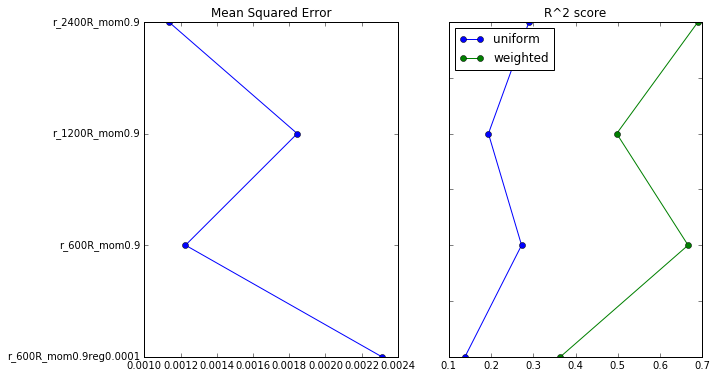

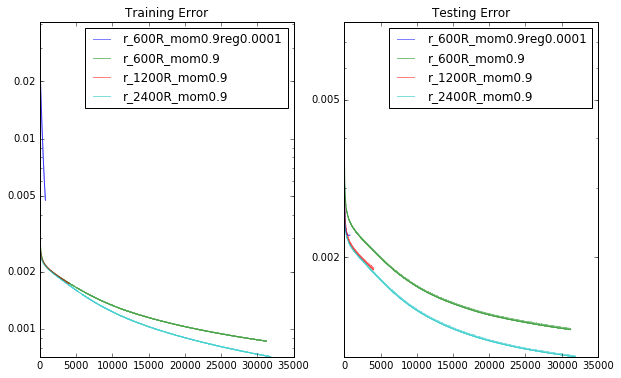

In [5]:
# Initialize regressors
from importlib import reload
reload(nntrain)
trained_regressors = ['r_600R_mom0.9reg0.0001','r_600R_mom0.9',
                      'r_1200R_mom0.9','r_2400R_mom0.9']
N_r = len(trained_regressors)
r_mlp = [0]*N_r
r_str = [0]*N_r
r_errors=np.empty((40000,4,N_r))
r_errors[:]=np.NAN

# Load regressors
for i,r in enumerate(trained_regressors):
    r_mlp[i], r_str[i], err = pickle.load(open(data_dir + 'regressors/' + r + '.pkl', 'rb'))
    r_errors[:len(err),:,i]      =  err
# Compare them and plot output
nntrain.plot_regressors_scores(r_mlp,r_str,x2,y2,fig_dir + 'compare/','r')
nntrain.plot_model_error_over_time(r_errors, r_str, fig_dir + 'compare/','r')

## Plot test data evaluations

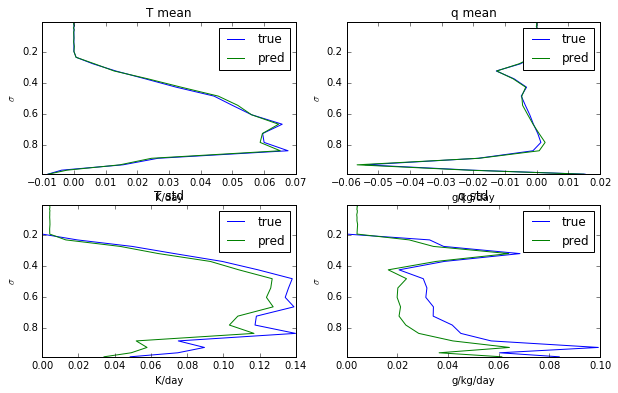

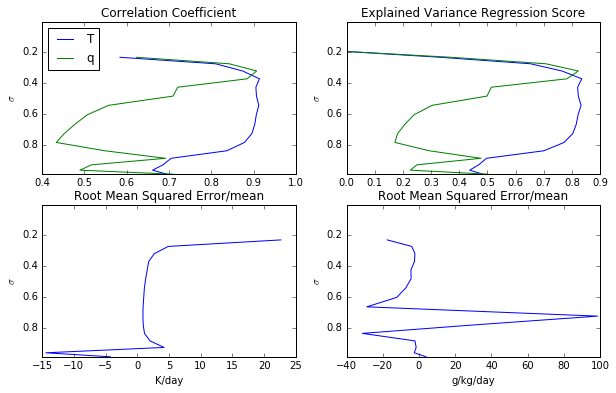

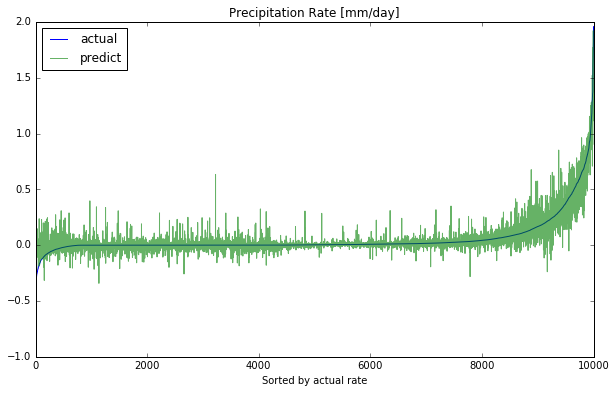

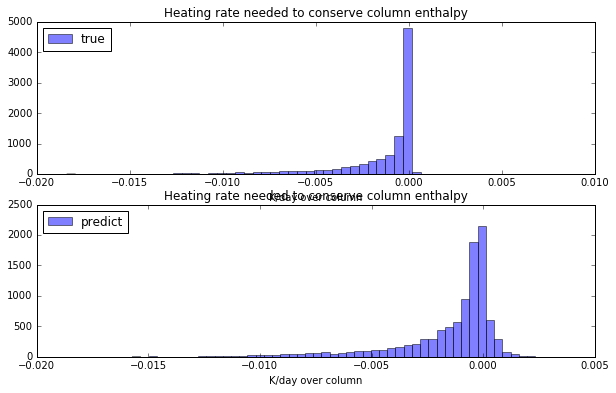

In [9]:
# Load the model we want to do a detailed evaulation for
r_str_eval = 'r_2400R_mom0.9'
r_mlp_eval, _, _ = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

# Set figure path and create directory if it does not exist
figpath = fig_dir + r_str_eval + '/'
if not os.path.exists(figpath):
    os.makedirs(figpath)
    
# Set the true and predicted test data
y3_true = y2
y3_pred = r_mlp_eval.predict(x2)

# Plot means and standard deviations
nnplot.plot_means_stds(y3_true, y3_pred, lev, figpath)

# Plot correlation coefficient, explained variance, and rmse
nnplot.plot_error_stats(y3_true, y3_pred, lev, figpath)

# Plot a time series of precipitaiton
nnplot.plot_precip(y3_true, y3_pred, dlev, figpath)

# Plot the enthalpy conservation
nnplot.plot_enthalpy(y3_true, y3_pred, dlev, figpath)

In [ ]:
#     r_mlp.append(build_nn('regress',['Rectifier','Rectifier']            ,[500,500]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Rectifier','Rectifier','Rectifier'],[200,200,200],n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh','Tanh']               ,[100,100,100],n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[200,200]    ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh']                             ,[500]        ,n_iter,batch_size,'momentum'))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'momentum',learning_momentum=0.7))
#     r_mlp.append(build_nn('regress',['Tanh','Tanh']                      ,[500,500]    ,n_iter,batch_size,'sgd'))

In [4]:
import pickle
r_str_eval = 'r_800R_mom0.9reg0.0001'
r_mlp_eval, _, _ = pickle.load(open(data_dir + 'regressors/' + r_str_eval + '.pkl', 'rb'))

